# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
!pip install --upgrade scikit-learn scipy imblearn s3fs boto3
!pip install xgboost imbalanced-learn category_encoders


  Using cached boto3-1.35.24-py3-none-any.whl.metadata (6.6 kB)
  Using cached botocore-1.35.24-py3-none-any.whl.metadata (5.7 kB)
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
  Using cached aiobotocore-2.15.0-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.14.0-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.13.3-py3-none-any.whl.metadata (22 kB)
  Using cached aiobotocore-2.13.2-py3-none-any.whl.metadata (22 kB)
  Using cached aiobotocore-2.13.1-py3-none-any.whl.metadata (22 kB)
  Using cached aiobotocore-2.13.0-py3-none-any.whl.metadata (21 kB)
  Using cached aiobotocore-2.12.4-py3-none-any.whl.metadata (21 kB)
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
  Using cached aiobotocore-2.12.3-py3-none-any.whl.metadata (21 kB)
  Using cached aiobotoc

In [30]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from pandas import DataFrame

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer

import xgboost as xgb

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import EditedNearestNeighbours



# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
import boto3
import sagemaker
from botocore.exceptions import NoCredentialsError

# Initialize a session using Amazon S3
s3_client = boto3.client('s3')

# Get the SageMaker execution role
role = sagemaker.get_execution_role()

# Get the current AWS region
region = boto3.Session().region_name

# Create a SageMaker session
session = sagemaker.Session()

# Set the default S3 bucket
default_bucket = session.default_bucket()

# Define the bucket name and the object key
bucket_name = default_bucket
train_dataset = 'data/Udacity_MAILOUT_052018_TRAIN.csv'
test_dataset = 'data/Udacity_MAILOUT_052018_TEST.csv'

# Generate a presigned URL for the S3 PUT operation
# try:
#     presigned_url1 = s3_client.generate_presigned_url(
#         'put_object',
#         Params={'Bucket': bucket_name, 'Key': object1_name},
#         ExpiresIn=3600  # URL expiration time in seconds
#     )
#     print(f"Presigned URL: {presigned_url1}")
#     presigned_url2 = s3_client.generate_presigned_url(
#         'put_object',
#         Params={'Bucket': bucket_name, 'Key': object2_name},
#         ExpiresIn=3600  # URL expiration time in seconds
#     )
#     print(f"Presigned URL: {presigned_url2}")
# except NoCredentialsError:
#     print("Credentials not available")

# Output the presigned URL

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## 1. Data

In [5]:
# Load the training data
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv(f's3://{default_bucket}/{train_dataset}', sep=';')

mailout_train.head()

/tmp/ipykernel_573/4068911945.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv(f's3://{default_bucket}/{train_dataset}', sep=';')


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Number of negative responses (RESPONSE = 0) in clean_mailout_train: 42430 (98.76%)
Number of positive responses (RESPONSE = 1) in clean_mailout_train: 532 (1.24%)


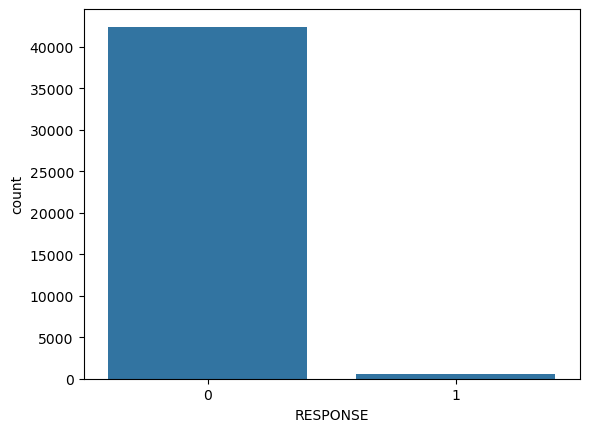

In [6]:
sns.countplot(x='RESPONSE', data=mailout_train)
responses = mailout_train['RESPONSE'].value_counts()
print(f"Number of negative responses (RESPONSE = 0) in clean_mailout_train: {responses[0]} ({(responses[0]/responses.sum() * 100):.2f}%)")
print(f"Number of positive responses (RESPONSE = 1) in clean_mailout_train: {responses[1]} ({(responses[1]/responses.sum() * 100):.2f}%)")

## 2. Analyzing features from DIAS Attributes - Values 2017.xlsx

In [7]:
# Find unknown features in DIAS Attributes - Values 2017.xlsx

# Read the Excel file, specifying the range and including the 'Attribute', 'Meaning', and 'Value' columns
dias_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', skiprows=1)

# Reset the index and rename the columns
dias_info = dias_info.reset_index(drop=True)
dias_info.columns = ['Attribute', 'Description', 'Value', 'Meaning']

# Drop rows with empty 'Attribute' values
# dias_info = dias_info.dropna(subset=['Attribute'])
dias_info['Attribute'] = dias_info['Attribute'].ffill()

# Print the number of rows remaining after dropping empty Attribute rows
# print(f"Number of rows after dropping empty Attribute values: {len(dias_info)}")

# Remove suffix '_RZ' from Attribute values
dias_info['Attribute'] = dias_info['Attribute'].str.replace('_RZ$', '', regex=True)

# Replace CAMEO_DEUINTL_2015 with CAMEO_INTL_2015 in the 'Attribute' column
dias_info.loc[dias_info['Attribute'] == 'CAMEO_DEUINTL_2015', 'Attribute'] = 'CAMEO_INTL_2015'

# KBA13_CCM_1400_2500 with KBA13_CCM_1401_2500
dias_info.loc[dias_info['Attribute'] == 'KBA13_CCM_1400_2500', 'Attribute'] = 'KBA13_CCM_1401_2500'

# SOHO_FLAG with SOHO_KZ
dias_info.loc[dias_info['Attribute'] == 'SOHO_FLAG', 'Attribute'] = 'SOHO_KZ'

# D19_KK_KUNDENTYP with KK_KUNDENTYP
dias_info.loc[dias_info['Attribute'] == 'D19_KK_KUNDENTYP', 'Attribute'] = 'KK_KUNDENTYP'

# D19_BUCH with D19_BUCH_CD
dias_info.loc[dias_info['Attribute'] == 'D19_BUCH', 'Attribute'] = 'D19_BUCH_CD'

# Reset the index after dropping rows
dias_info = dias_info.reset_index(drop=True)

# Drop the 'Description' column
dias_info = dias_info.drop('Description', axis=1)

# Find rows where 'Meaning' is unknown
unknown_rows = dias_info[dias_info['Meaning'].isin(['unknown', 'no transaction known', 'no transactions known'])].astype(str)

# Print the total number of unknown rows
print(f"\nTotal number of rows with unknown values: {len(unknown_rows)}")

# Filter rows where Value is -1, 0, or 9, 10
features_unknown_0 = unknown_rows[unknown_rows['Value'].str.contains('^0|, 0$', regex=True)].reset_index(drop=True)['Attribute'].tolist()
features_unknown_9 = unknown_rows[unknown_rows['Value'].str.contains('9')].reset_index(drop=True)['Attribute'].tolist()
features_unknown_10 = unknown_rows[unknown_rows['Value'].str.contains('10')].reset_index(drop=True)['Attribute'].tolist()



Total number of rows with unknown values: 288


## 3. Data Preprocessing

In [361]:
mailout_train['CAMEO_INTL_2015'].unique()

array([34.0, 32.0, 14.0, 41.0, 24.0, 33.0, nan, 25.0, 31.0, 22.0, 43.0,
       13.0, 55.0, 23.0, 54.0, 51.0, 45.0, 12.0, 44.0, 35.0, 15.0, 52.0,
       '23', '44', '14', '55', '51', '45', '43', '22', '54', '24', '25',
       '13', '12', '35', '33', '41', '15', '52', '31', '32', '34', 'XX'],
      dtype=object)

In [355]:

def check_abnormal_number_data(df):
    # Calculate the difference between consecutive rows
    diff_rows = df.diff(axis=1)

    # Get the largest difference for each feature
    largest_diff = diff_rows.max()
    top8_diff = largest_diff.sort_values(ascending=False)[: 8]
    
    for feature, _ in top8_diff.items():
        print(df[feature].unique())

def replace_special_data_with_nan(df, columns=None, special_value=-1):
    """
    Replace special values with NaN.
    
    :param df: pandas DataFrame
    :param columns: list of column names to process (optional)
    :param special_value: value to be replaced with NaN (default -1)
    :return: DataFrame with special values replaced with NaN
    """
    if columns is None:
        columns = df.columns
    
    for column in columns:
        
        if column in df.columns and df[column].dtype in ['int8', 'int32', 'int64', 'float32', 'float64']:
            
            # Replace special values with NaN
            df.loc[df[column] == special_value, column] = np.nan
    
    return df

def clean_data(df: DataFrame):
    
    # Replace 'XX' values with NaN
    columns_to_replace_XX = ['CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    df.loc[:, columns_to_replace_XX] = df[columns_to_replace_XX].replace('XX', np.nan)
    
    # Replace 'X' values with NaN
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    
    # Convert string value to float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float32')
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('float32')
    
    # Convert to category codes
    df['D19_LETZTER_KAUF_BRANCHE'] = pd.Categorical(df['D19_LETZTER_KAUF_BRANCHE']).codes
    df['CAMEO_DEU_2015'] = pd.Categorical(df['CAMEO_DEU_2015']).codes
    df['OST_WEST_KZ'] = pd.Categorical(df['OST_WEST_KZ']).codes
    
    # Featuring datetime feature
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'], errors='coerce')
    df['hour'] = df['EINGEFUEGT_AM'].dt.hour
    df['day_of_week'] = df['EINGEFUEGT_AM'].dt.dayofweek
    df['month'] = df['EINGEFUEGT_AM'].dt.month
    df.drop(columns=['EINGEFUEGT_AM'], inplace=True)
    
    # Replace special values with NaN for different feature groups
    # Replace 0 value of year of birth
    features_unknown_0.extend(['GEBURTSJAHR', 'LP_FAMILIE_GROB'])
    df = replace_special_data_with_nan(df)
    df = replace_special_data_with_nan(df, features_unknown_0, 0)
    df = replace_special_data_with_nan(df, features_unknown_9, 9)
    df = replace_special_data_with_nan(df, features_unknown_10, 10)
    
    # Remove features with more than 30% missing values
    threshold = int(len(df) * 0.7)
    df = df.dropna(thresh=threshold, axis=1)

    # Ensure consistency in data formats
    for column in df.columns:
        if df[column].dtype == 'int64':
            df.loc[:, column] = df[column].astype('int32')
        elif df[column].dtype == 'float64':
            df.loc[:, column] = df[column].astype('float32')

    # Reset index
    df = df.reset_index(drop=True)
    
    # Drop the LNR column
    if 'LNR' in df.columns:
        df = df.drop('LNR', axis=1)
        
    print(f'Existing data types: {df.dtypes.unique()}')
    
    return df

In [356]:
# Clean the training data
clean_mailout_train = clean_data(mailout_train.copy())
print("Matched features cleaned mailout_train shape:", clean_mailout_train.shape)

Existing data types: [dtype('float64') dtype('float32')]
Matched features cleaned mailout_train shape: (42962, 368)


Columns with more than 30% missing values:
['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12

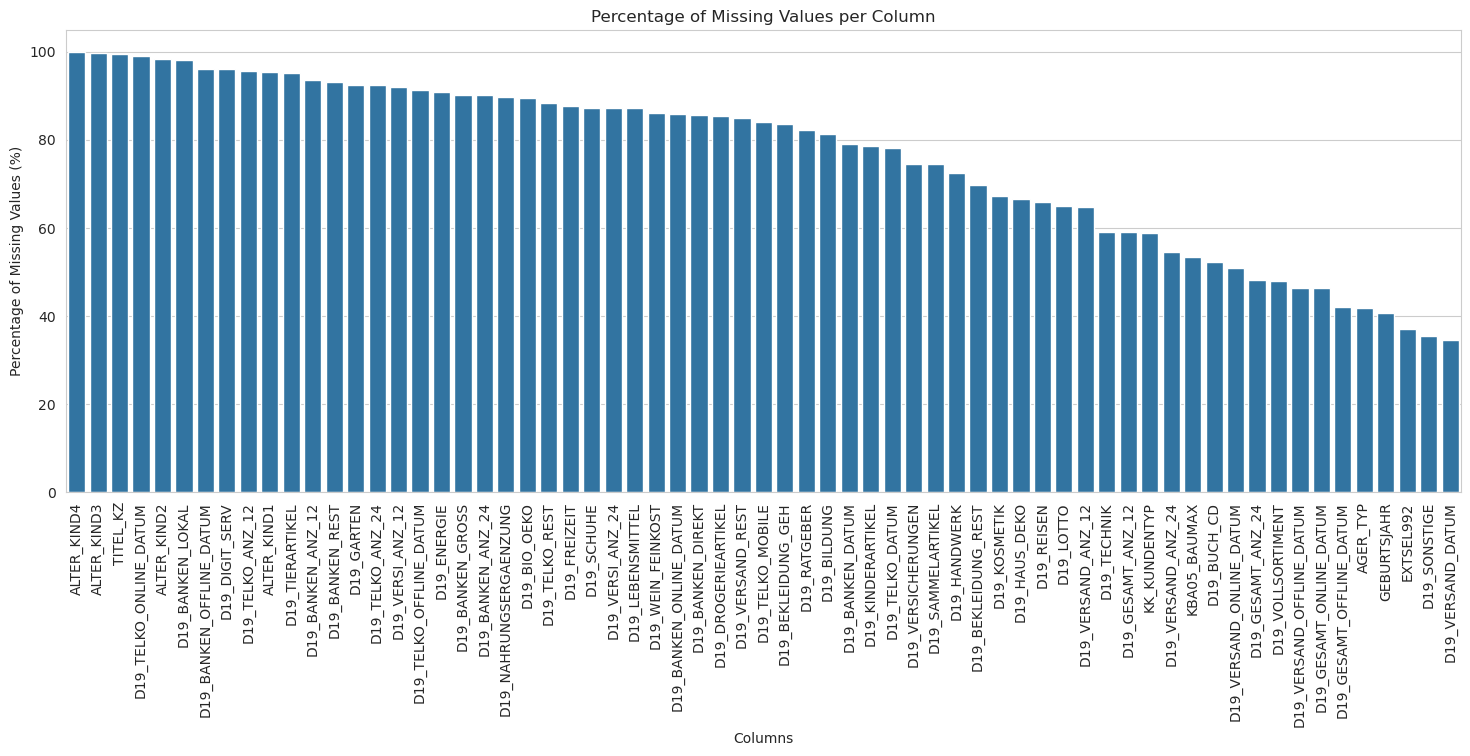

In [360]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming clean_mailout_train is your DataFrame
# Calculate percentage of missing values per column
missing_values_percentage = (clean_mailout_train.isnull().sum() / len(clean_mailout_train)) * 100

# Filter columns with more than 30% missing values
columns_over_30_nan = missing_values_percentage[missing_values_percentage > 30]

# List the columns
print("Columns with more than 30% missing values:")
print(columns_over_30_nan.index.tolist())

# Assuming clean_mailout_train is your DataFrame
# Calculate percentage of missing values per column
missing_values_percentage = (clean_mailout_train.isnull().sum() / len(clean_mailout_train)) * 100

# Filter out columns with no missing values
missing_values_percentage = missing_values_percentage[missing_values_percentage > 0]

# Sort the missing values percentage
columns_over_30_nan = columns_over_30_nan.sort_values(ascending=False)

# Convert to DataFrame for Seaborn
missing_values_df = columns_over_30_nan.reset_index()
missing_values_df.columns = ['Column', 'Percentage']


# Create a bar plot for percentage of missing values using a Seaborn palette
plt.figure(figsize=(18, 6))
sns.barplot(x=columns_over_30_nan.index, y=columns_over_30_nan.values)
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values (%)')

# Set abbreviated labels
plt.xticks(rotation=90)

plt.show()

##### 3.2 Prepare training, validation data

In [10]:
# Prepare the features and target
X = clean_mailout_train.drop('RESPONSE', axis=1)
y = clean_mailout_train['RESPONSE']

# Select expected features
expected_features = X.columns.tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# Optional: Check the shapes of the resulting datasets
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")

Training set shape: (25777, 302), Validation set shape: (17185, 302)


In [11]:
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
X_impute = imputer.fit_transform(X)

# Cast the NumPy array back to a DataFrame
X_impute_df = pd.DataFrame(X_impute, columns=X.columns)

# Split the data into training and validation sets
X_train_impute, X_val_impute, y_train, y_val = train_test_split(X_impute_df, y, test_size=0.4, random_state=42)

In [12]:
# Class weighting
positive_responses = y.sum()
negative_responses = len(y) - positive_responses
class_weights = {0: 1, 1: round(negative_responses / positive_responses)}

## 4. Metrics

In [13]:
metrics_score = pd.DataFrame(columns=['Model Name', 'Technique','ROC_AUC', 'Recall','Precision','F1 Score', 'Accuracy'])

# Set 'Model Name' and 'Technique' as key columns (index)
metrics_score.set_index(['Model Name', 'Technique'], inplace=True)

# Reset the index to make 'Model Name' and 'Technique' appear as the first columns
metrics_score.reset_index(inplace=True)

def cal_metrics(model_name: str, tech: str, y_val, y_pred, y_pred_proba, metrics_score):
    # Calculate metrics
    auc = roc_auc_score(y_val, y_pred_proba)
    print(f"{model_name} - Validation AUC: {auc:.4f}")

    print("Model Performance Results:")
    print(classification_report(y_val, y_pred))
    
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    
    data = {
        'Model Name': [model_name],
        'Technique': [tech],
        'ROC_AUC': [auc],
        'Recall': [recall],
        'Precision': [precision],
        'F1 Score': [f1],
        'Accuracy': [accuracy]
    }
    
    new_data = pd.DataFrame(data)
    
    metrics_score = pd.concat([metrics_score, new_data], ignore_index=True).drop_duplicates(subset=['Model Name', 'Technique'], keep='last')

    # Present confusion matrix to evaluate the accuracy of a classification 
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap='Blues')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()
    
    return metrics_score


## 5. Algorithms

### 5.1 Random Forest Without Over/Under Sample

Metric: Recall (Identifying potential customers holds greater value than focusing on excluding non-potential ones.)

In [14]:
# Stratified K-Fold CV (Cross-Validation)
kf = StratifiedKFold(n_splits=5, shuffle=False)

# Random Forest Classifier without over sample
rf = RandomForestClassifier(n_estimators=100, random_state=13)

# Hyperparameter Tuning Using GridSearchCV
params = {
    'n_estimators': [320, 400, 480],
    'max_depth': [5, 6, 8],
    'random_state': [13],
    'min_weight_fraction_leaf': [0.055]
}

In [15]:
# Create and fit GridSearchCV
grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall', verbose=1, n_jobs=-1).fit(X_train_impute, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [16]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 5, 'min_weight_fraction_leaf': 0.055, 'n_estimators': 320, 'random_state': 13}
Best score: 0.0


`Best score: 0.0` is a useless value, we will ignore it for this part

### 5.2 Random Resampling Imbalanced Datasets

#### 5.2.1 Random Oversampling

In [17]:
# Define the pipeline
random_overs_pipeline = ImbPipeline([
    ('over', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=13))
])

new_params = {'classifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='recall', return_train_score=True, verbose=1, n_jobs=-1)
grid_over_rf.fit(X_train_impute, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 6, 8],
                         'classifier__min_weight_fraction_leaf': [0.055],
                         'classifier__n_estimators': [320, 400, 480],
                         'classifier__random_state': [13]},
             return_train_score=True, scoring='recall', verbose=1)

In [18]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

Best parameters: {'classifier__max_depth': 5, 'classifier__min_weight_fraction_leaf': 0.055, 'classifier__n_estimators': 400, 'classifier__random_state': 13}
Best score: 0.5509984639016897


Random Forest - Validation AUC: 0.7300
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86     16967
         1.0       0.03      0.54      0.05       218

    accuracy                           0.76     17185
   macro avg       0.51      0.65      0.46     17185
weighted avg       0.98      0.76      0.85     17185



/tmp/ipykernel_573/308883122.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_score = pd.concat([metrics_score, new_data], ignore_index=True).drop_duplicates(subset=['Model Name', 'Technique'], keep='last')


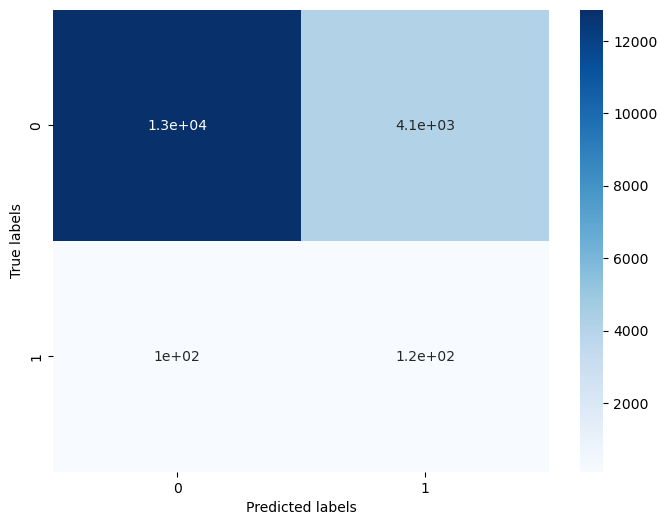

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252


In [19]:
# Make predictions on the validation set
classifier = grid_over_rf.best_estimator_.named_steps['classifier']
y_pred_proba = classifier.predict_proba(X_val_impute)[:, 1]  # Get probabilities for the positive class
y_pred = classifier.predict(X_val_impute)  # Convert probabilities to binary predictions

# Visualizing model performance metrics
metrics_score = cal_metrics('Random Forest', 'RandomOverSampler', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

#### 5.2.2 SMOTE (Synthetic Minority Oversampling Technique)
Note: I will skip `Random Undersampling Imbalanced Datasets` because we will have a very small sample of data

In [20]:
random_smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=13))
])

new_params = {'classifier__' + key: params[key] for key in params}
smote_rf = GridSearchCV(random_smote_pipeline, param_grid=new_params, cv=kf, scoring='recall', return_train_score=True, verbose=1, n_jobs=-1)
smote_rf.fit(X_train_impute, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 6, 8],
                         'classifier__min_weight_fraction_leaf': [0.055],
                         'classifier__n_estimators': [320, 400, 480],
                         'classifier__random_state': [13]},
             return_train_score=True, scoring='recall', verbose=1)

In [21]:
print('Best parameters:', smote_rf.best_params_)
print('Best score:', smote_rf.best_score_)

Best parameters: {'classifier__max_depth': 5, 'classifier__min_weight_fraction_leaf': 0.055, 'classifier__n_estimators': 400, 'classifier__random_state': 13}
Best score: 0.1719406041986687


Random Forest - Validation AUC: 0.6369
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     16967
         1.0       0.03      0.13      0.05       218

    accuracy                           0.93     17185
   macro avg       0.51      0.54      0.51     17185
weighted avg       0.98      0.93      0.95     17185



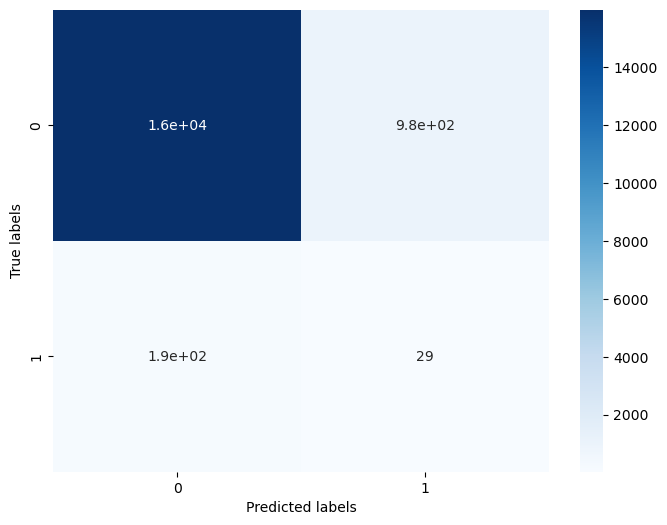

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252
1,Random Forest,SMOTE,0.636855,0.133028,0.028856,0.047424,0.932208


In [22]:
# Make predictions on the validation set
classifier = smote_rf.best_estimator_.named_steps['classifier']
y_pred_proba = classifier.predict_proba(X_val_impute)[:, 1]  # Get probabilities for the positive class
y_pred = classifier.predict(X_val_impute)  # Convert probabilities to binary predictions

# Visualizing model performance metrics
metrics_score = cal_metrics('Random Forest', 'SMOTE', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

#### 5.2.3 Combining SMOTE and Tomek Links
A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance than only under-sampling the majority class. This method was first introduced by Batista et al. (2003).

In [44]:
random_smotetom_pipeline = ImbPipeline([
    ('smote', SMOTETomek(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=13))
])

smote_tom_rf = GridSearchCV(random_smotetom_pipeline, param_grid=new_params, cv=kf, scoring='recall', return_train_score=True, verbose=1, n_jobs=-1)
smote_tom_rf.fit(X_train_impute, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTETomek(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 6, 8],
                         'classifier__min_weight_fraction_leaf': [0.055],
                         'classifier__n_estimators': [320, 400, 480],
                         'classifier__random_state': [13]},
             return_train_score=True, scoring='recall', verbose=1)

In [45]:
print('Best parameters:', smote_tom_rf.best_params_)
print('Best score:', smote_tom_rf.best_score_)

Best parameters: {'classifier__max_depth': 5, 'classifier__min_weight_fraction_leaf': 0.055, 'classifier__n_estimators': 400, 'classifier__random_state': 13}
Best score: 0.1719406041986687


Random Forest - Validation AUC: 0.6369
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     16967
         1.0       0.03      0.13      0.05       218

    accuracy                           0.93     17185
   macro avg       0.51      0.54      0.51     17185
weighted avg       0.98      0.93      0.95     17185



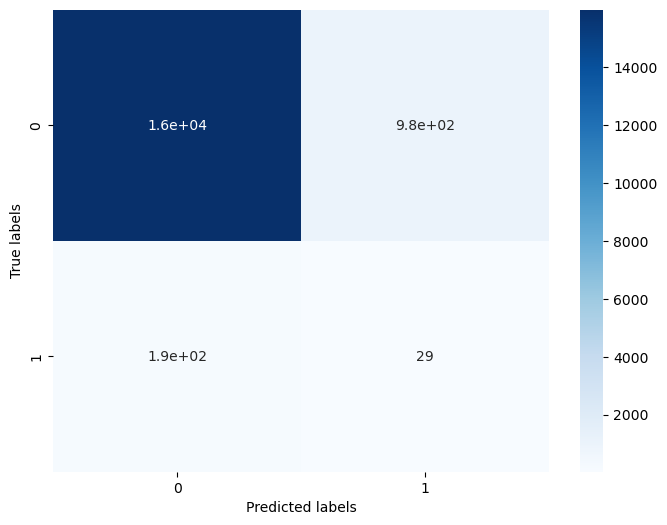

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252
1,Random Forest,SMOTE,0.636855,0.133028,0.028856,0.047424,0.932208
3,Random Forest,SMOTE ENN,0.652443,0.321101,0.029724,0.054411,0.858423
4,Random Forest,SMOTE Tomek,0.636855,0.133028,0.028856,0.047424,0.932208


In [46]:
# Make predictions on the validation set
classifier = smote_tom_rf.best_estimator_.named_steps['classifier']
y_pred_proba = classifier.predict_proba(X_val_impute)[:, 1]  # Get probabilities for the positive class
y_pred = classifier.predict(X_val_impute)  # Convert probabilities to binary predictions

# Visualizing model performance metrics
metrics_score = cal_metrics('Random Forest', 'SMOTE Tomek', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

#### 5.2.3 Combining SMOTE and Edited Nearest Neighbours
Developed by Wilson (1972), the ENN method works by finding the K-nearest neighbor of each observation first, then check whether the majority class from the observation’s k-nearest neighbor is the same as the observation’s class or not.

In [47]:
random_smoteenn_pipeline = ImbPipeline([
    ('smote', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)),
    ('classifier', RandomForestClassifier(random_state=13))
])

smote_enn_rf = GridSearchCV(random_smoteenn_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                            return_train_score=True, verbose=1, n_jobs=-1)
smote_enn_rf.fit(X_train_impute, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote',
                                        SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'),
                                                 random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 6, 8],
                         'classifier__min_weight_fraction_leaf': [0.055],
                         'classifier__n_estimators': [320, 400, 480],
                         'classifier__random_state': [13]},
             return_train_score=True, scoring='recall', verbose=1)

In [48]:
print('Best parameters:', smote_enn_rf.best_params_)
print('Best score:', smote_enn_rf.best_score_)

Best parameters: {'classifier__max_depth': 5, 'classifier__min_weight_fraction_leaf': 0.055, 'classifier__n_estimators': 320, 'classifier__random_state': 13}
Best score: 0.2674859190988223


Random Forest - Validation AUC: 0.6524
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92     16967
         1.0       0.03      0.32      0.05       218

    accuracy                           0.86     17185
   macro avg       0.51      0.59      0.49     17185
weighted avg       0.98      0.86      0.91     17185



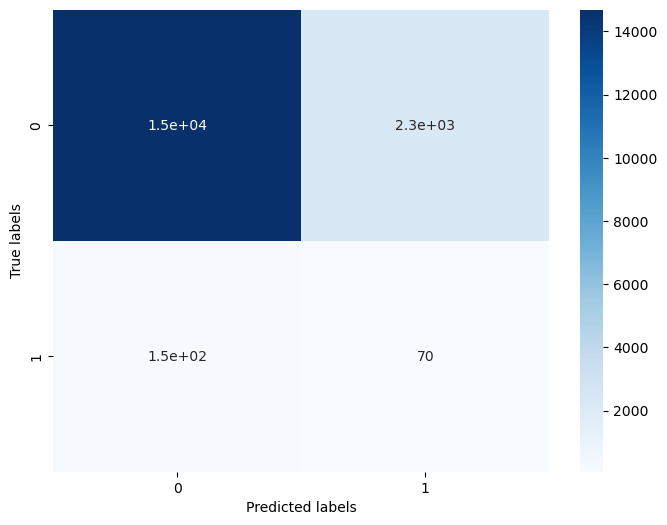

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252
1,Random Forest,SMOTE,0.636855,0.133028,0.028856,0.047424,0.932208
3,Random Forest,SMOTE Tomek,0.636855,0.133028,0.028856,0.047424,0.932208
4,Random Forest,SMOTE ENN,0.652443,0.321101,0.029724,0.054411,0.858423


In [49]:
# Make predictions on the validation set
classifier = smote_enn_rf.best_estimator_.named_steps['classifier']
y_pred_proba = classifier.predict_proba(X_val_impute)[:, 1]  # Get probabilities for the positive class
y_pred = classifier.predict(X_val_impute)  # Convert probabilities to binary predictions

# Visualizing model performance metrics
metrics_score = cal_metrics('Random Forest', 'SMOTE ENN', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

### 5.3 Class weights in the models

In [50]:
# Hyperparameter Tuning Using GridSearchCV
params = {
    'n_estimators': [460, 480, 500],
    'max_depth': [5, 6, 7],
    'random_state': [13],
    'min_weight_fraction_leaf': [0.055]
}

# Define hyperparameters for Random Forest Classifier
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight=class_weights)
grid_rfb = GridSearchCV(rfb, param_grid=params, cv=kf, 
                          scoring='recall', verbose=1, n_jobs=-1).fit(X_train_impute, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [60]:
print('Best parameters:', grid_rfb.best_params_)
print('Best score:', grid_rfb.best_score_)

Best parameters: {'max_depth': 5, 'min_weight_fraction_leaf': 0.055, 'n_estimators': 460, 'random_state': 13}
Best score: 0.410752688172043


Random Forest - Validation AUC: 0.7364
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     16967
         1.0       0.03      0.50      0.06       218

    accuracy                           0.81     17185
   macro avg       0.51      0.66      0.48     17185
weighted avg       0.98      0.81      0.89     17185



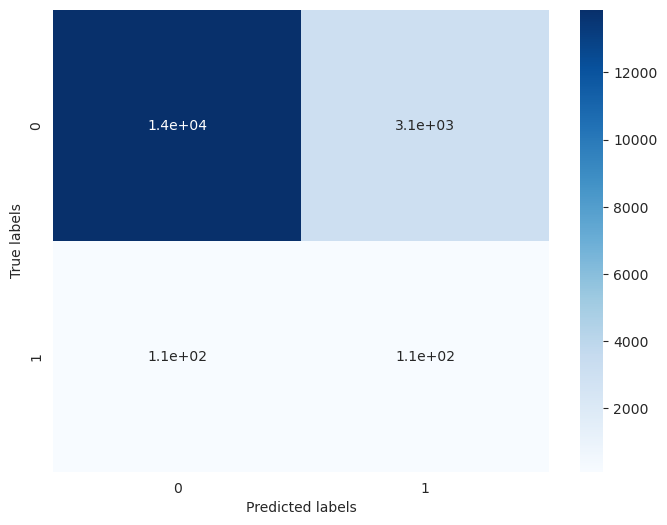

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252
1,Random Forest,SMOTE,0.636855,0.133028,0.028856,0.047424,0.932208
2,Random Forest,SMOTE Tomek,0.636855,0.133028,0.028856,0.047424,0.932208
3,Random Forest,SMOTE ENN,0.652443,0.321101,0.029724,0.054411,0.858423
5,Random Forest,class_weight,0.736374,0.495413,0.033687,0.063084,0.813326


In [85]:
# Make predictions on the validation set
y_pred_proba = grid_rfb.predict_proba(X_val_impute)[:, 1]  # Get probabilities for the positive class
y_pred = grid_rfb.predict(X_val_impute)  # Convert probabilities to binary predictions

# Visualizing model performance metrics
metrics_score = cal_metrics('Random Forest', 'class_weight', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

#### 5.3.1 Class weights with Self-Training
We take the parameters from the previous learning

In [81]:
# Load the test data (use as unlabeled data)
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv(f's3://{default_bucket}/{test_dataset}', sep=';')


/tmp/ipykernel_573/1382474118.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv(f's3://{default_bucket}/{test_dataset}', sep=';')


In [97]:
# Clean the test data
test_data = clean_data(mailout_test.copy())
print("Matched features cleaned mailout_train shape:", test_data.shape)

Existing data types: [dtype('float64') dtype('float32')]
Matched features cleaned mailout_train shape: (42833, 302)


In [98]:
# Define hyperparameters for Random Forest Classifier
hyperparameters = {
    'n_jobs':-1
}
hyperparameters.update(best_params)
hyperparameters

{'n_jobs': -1,
 'max_depth': 5,
 'min_weight_fraction_leaf': 0.055,
 'n_estimators': 460,
 'random_state': 13}

In [267]:
def self_train(classifier, X_train, y_train, X_val, y_val, X_unlabeled):
    
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    train_recalls = []
    test_recalls = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]
    
    # Asign default threshold
    based_threshold_0 = 0.7
    based_threshold_1 = 0.6

    # Loop will run until there are no more high-probability pseudo-labels
    while (len(high_prob) > 0) & (len(X_unlabeled) > 0):
            
        # Fit classifier and make train/test predictions
        # Train the classifier on the labeled data
        classifier.fit(X_train, y_train)
        y_hat_train = classifier.predict(X_train)
        y_hat_test = classifier.predict(X_val)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        train_recall = recall_score(y_train, y_hat_train)
        test_recall = recall_score(y_val, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Train recall: {train_recall}")
        print(f"Test recall: {test_recall}")
        train_recalls.append(train_recall)
        test_recalls.append(test_recall)
    
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = classifier.predict_proba(X_unlabeled)
        preds = classifier.predict(X_unlabeled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]
        
                
        max_prob_0 = int(prob_0.max() * 100) / 100
        max_prob_1 = np.partition(prob_1, -3)[-3] # prob_1.max()
        # print(np.partition(prob_1, -3)[-3])
        
        new_threshold_0 = max_prob_0 if max_prob_0 > based_threshold_0 else based_threshold_0
        new_threshold_1 = max_prob_1 if max_prob_1 > based_threshold_1 else based_threshold_1

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabeled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > new_threshold_0],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > new_threshold_1]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds])      
        
        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
        
        based_threshold_0 = new_threshold_0
        based_threshold_1 = new_threshold_1
        
        # Update iteration counter
        iterations += 1
        
    return classifier, iterations, test_recalls, pseudo_labels



In [262]:
rf_classifier = RandomForestClassifier(**hyperparameters, class_weight=class_weights)

classifier, iterations, test_recalls, pseudo_labels = self_train(rf_classifier, X_train_impute, y_train, X_val_impute, y_val, test_data.copy())

Iteration 0
Train recall: 0.6305732484076433
Test recall: 0.4954128440366973
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
42832 unlabeled instances remaining.

Iteration 1
Train recall: 0.6242038216560509
Test recall: 0.4954128440366973
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
42832 unlabeled instances remaining.



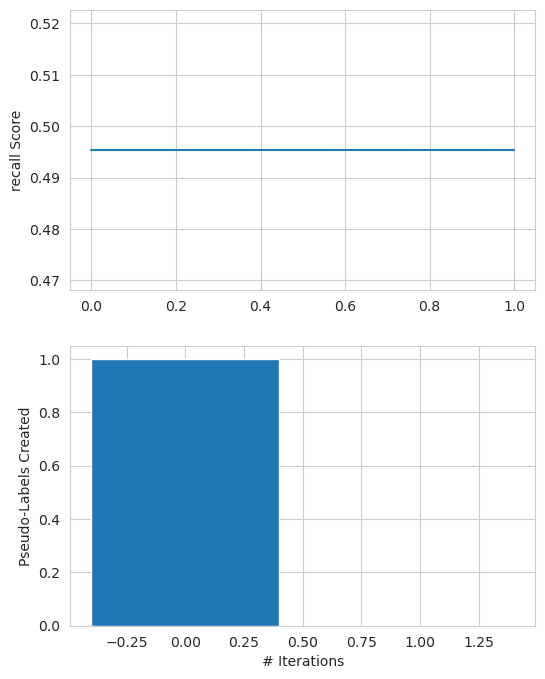

In [263]:
# Plot f1 scores and number of pseudo-labels added for all iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_recalls)
ax1.set_ylabel('recall Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');


Random Forest - Validation AUC: 0.7366
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     16967
         1.0       0.03      0.50      0.06       218

    accuracy                           0.81     17185
   macro avg       0.51      0.66      0.48     17185
weighted avg       0.98      0.81      0.89     17185



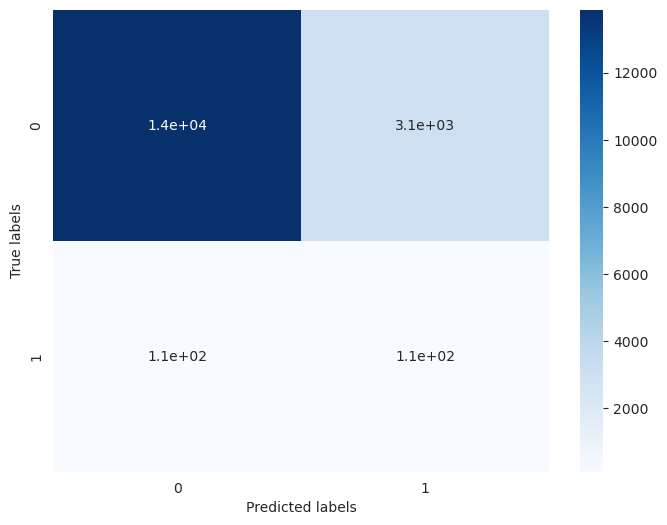

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252
1,Random Forest,SMOTE,0.636855,0.133028,0.028856,0.047424,0.932208
2,Random Forest,SMOTE Tomek,0.636855,0.133028,0.028856,0.047424,0.932208
3,Random Forest,SMOTE ENN,0.652443,0.321101,0.029724,0.054411,0.858423
4,Random Forest,class_weight,0.736374,0.495413,0.033687,0.063084,0.813326
6,XGBoost,scale_pos_weight,0.768904,0.701835,0.035003,0.066681,0.750771
7,XGBoost,scale_pos_weight & self_training,0.768915,0.701835,0.035027,0.066725,0.750946
8,Random Forest,class_weight & self_training,0.736648,0.495413,0.033750,0.063195,0.813675


In [264]:
# Make predictions on the validation set
y_pred_proba = classifier.predict_proba(X_val_impute)[:, 1]  # Get probabilities for the positive class
y_pred = classifier.predict(X_val_impute)  # Convert probabilities to binary predictions

# Visualizing model performance metrics
metrics_score = cal_metrics('Random Forest', 'class_weight & self_training', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

### 5.4 XGBOOST

In [149]:
param_grid = {
    'n_estimators': [130],
    'max_depth': [1],
    'learning_rate': [0.023],
    'random_state': [13],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 0.75],
    'max_delta_step': [1],
    'alpha': [0.5, 0.4],
    'lambda': [1, .9]
}

# Set XGBoost parameters with regularization and adjusted subsampling
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': negative_responses / positive_responses,  # Handle class imbalance
}

In [144]:
model = xgb.XGBClassifier(**params)

grid_xgbc = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
).fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [145]:
print('Best parameters:', grid_xgbc.best_params_)
print('Best score:', grid_xgbc.best_score_)

Best parameters: {'alpha': 0.5, 'colsample_bytree': 0.8, 'lambda': 1, 'learning_rate': 0.023, 'max_delta_step': 1, 'max_depth': 1, 'n_estimators': 130, 'random_state': 13, 'subsample': 0.8}
Best score: 0.7480798771121352


XGBoost - Validation AUC: 0.7689
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.86     16967
         1.0       0.04      0.70      0.07       218

    accuracy                           0.75     17185
   macro avg       0.51      0.73      0.46     17185
weighted avg       0.98      0.75      0.85     17185



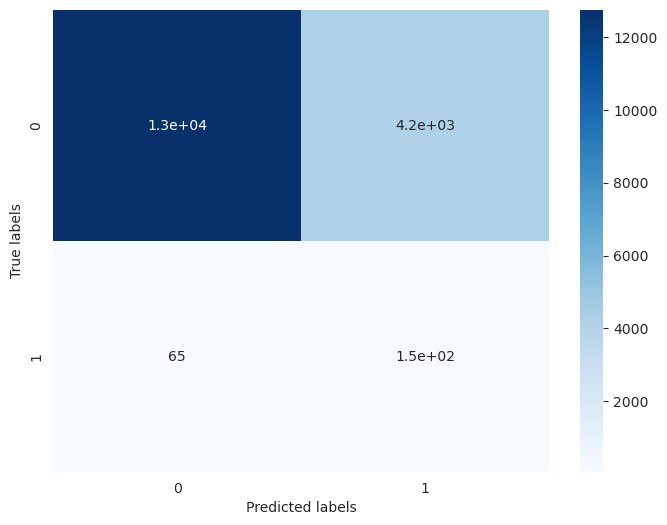

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252
1,Random Forest,SMOTE,0.636855,0.133028,0.028856,0.047424,0.932208
2,Random Forest,SMOTE Tomek,0.636855,0.133028,0.028856,0.047424,0.932208
3,Random Forest,SMOTE ENN,0.652443,0.321101,0.029724,0.054411,0.858423
4,Random Forest,class_weight,0.736374,0.495413,0.033687,0.063084,0.813326
6,XGBoost,scale_pos_weight & self_training,0.768915,0.701835,0.035027,0.066725,0.750946
7,Random Forest,class_weight & self_training,0.736648,0.495413,0.033750,0.063195,0.813675
8,XGBoost,scale_pos_weight,0.768904,0.701835,0.035003,0.066681,0.750771


In [265]:
# Get probabilities for the positive class
y_pred_proba = grid_xgbc.predict_proba(X_val)[:, 1]

# Convert probabilities to binary predictions
y_pred = grid_xgbc.predict(X_val)

# Visualizing model performance metrics
metrics_score = cal_metrics('XGBoost', 'scale_pos_weight', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

In [268]:
xgbc_best_params = grid_xgbc.best_params_
params.update(xgbc_best_params)
xgbc_model = xgb.XGBClassifier(**params)
xgbc_classifier, iterations, test_recalls, pseudo_labels = self_train(xgbc_model, X_train, y_train, X_val, y_val, test_data.copy())

Iteration 0
Train recall: 0.7038216560509554
Test recall: 0.7018348623853211
Now predicting labels for unlabeled data...
418 high-probability predictions added to training data.
42415 unlabeled instances remaining.

Iteration 1
Train recall: 0.7038216560509554
Test recall: 0.7018348623853211
Now predicting labels for unlabeled data...
738 high-probability predictions added to training data.
41677 unlabeled instances remaining.

Iteration 2
Train recall: 0.7038216560509554
Test recall: 0.7018348623853211
Now predicting labels for unlabeled data...
163 high-probability predictions added to training data.
41514 unlabeled instances remaining.

Iteration 3
Train recall: 0.7038216560509554
Test recall: 0.7018348623853211
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
41514 unlabeled instances remaining.



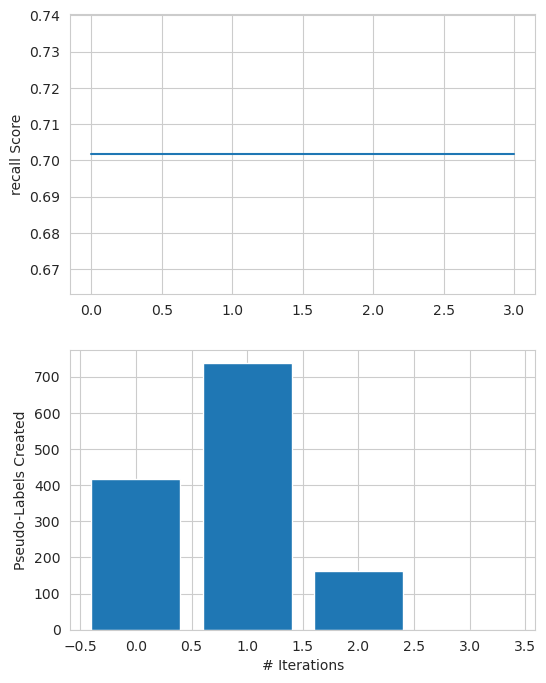

In [269]:
# Plot f1 scores and number of pseudo-labels added for all iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_recalls)
ax1.set_ylabel('recall Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

XGBoost - Validation AUC: 0.7689
Model Performance Results:
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.86     16967
         1.0       0.04      0.70      0.07       218

    accuracy                           0.75     17185
   macro avg       0.51      0.73      0.46     17185
weighted avg       0.98      0.75      0.85     17185



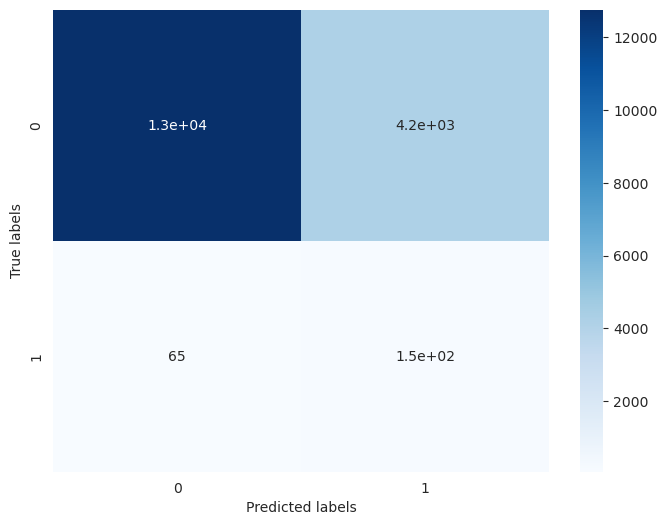

,Model Name,Technique,ROC_AUC,Recall,Precision,F1 Score,Accuracy
0,Random Forest,RandomOverSampler,0.729993,0.541284,0.027936,0.053129,0.755252
1,Random Forest,SMOTE,0.636855,0.133028,0.028856,0.047424,0.932208
2,Random Forest,SMOTE Tomek,0.636855,0.133028,0.028856,0.047424,0.932208
3,Random Forest,SMOTE ENN,0.652443,0.321101,0.029724,0.054411,0.858423
4,Random Forest,class_weight,0.736374,0.495413,0.033687,0.063084,0.813326
5,Random Forest,class_weight & self_training,0.736648,0.495413,0.033750,0.063195,0.813675
6,XGBoost,scale_pos_weight,0.768904,0.701835,0.035003,0.066681,0.750771
8,XGBoost,scale_pos_weight & self_training,0.768915,0.701835,0.035027,0.066725,0.750946


In [270]:
# Get probabilities for the positive class
y_pred_proba = xgbc_classifier.predict_proba(X_val)[:, 1]

# Convert probabilities to binary predictions
y_pred = xgbc_classifier.predict(X_val)

# Visualizing model performance metrics
metrics_score = cal_metrics('XGBoost', 'scale_pos_weight & self_training', y_val, y_pred, y_pred_proba, metrics_score)
metrics_score

                   Feature  Importance
25           D19_KONSUMTYP    0.228946
28            D19_SOZIALES    0.222276
26       D19_KONSUMTYP_MAX    0.203213
264        RT_SCHNAEPPCHEN    0.139165
2     ALTERSKATEGORIE_FEIN    0.110995
259  PRAEGENDE_JUGENDJAHRE    0.095406
206           KBA13_NISSAN    0.000000
205            KBA13_MOTOR    0.000000
190       KBA13_KRSZUL_NEU    0.000000
191          KBA13_KW_0_60    0.000000



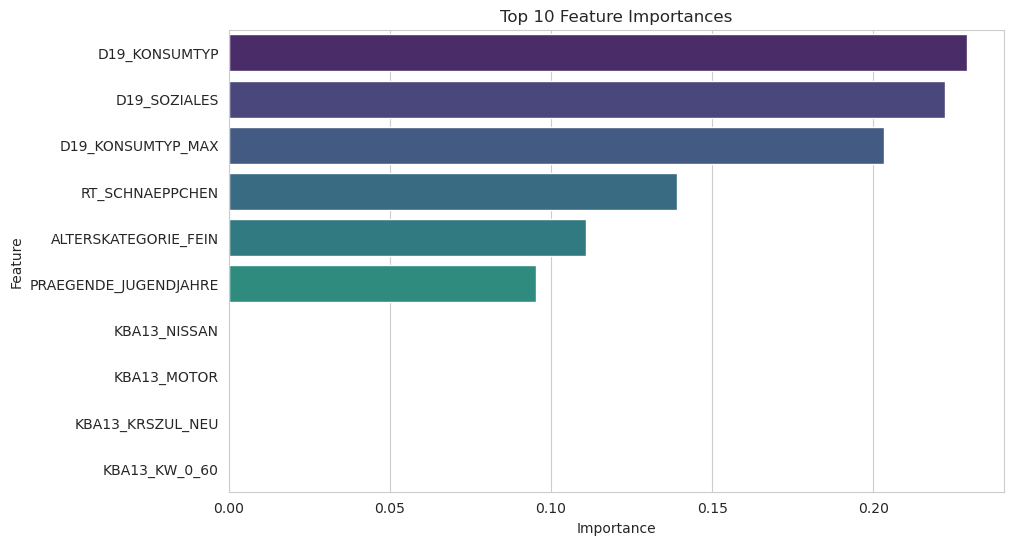

In [288]:
# Extract feature importance
feature_importances = xgbc_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))
print()

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df.head(10), palette='viridis', legend=False)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


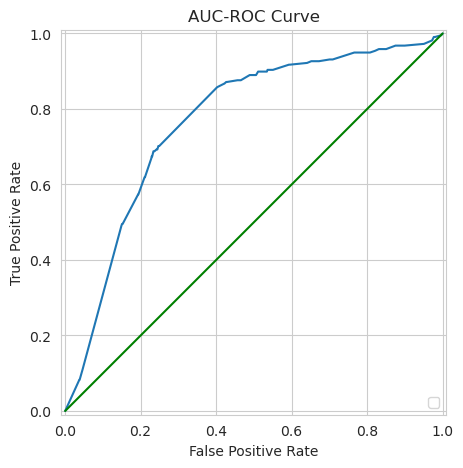

In [294]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.figure_.set_size_inches(5,5)
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('AUC-ROC Curve')
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


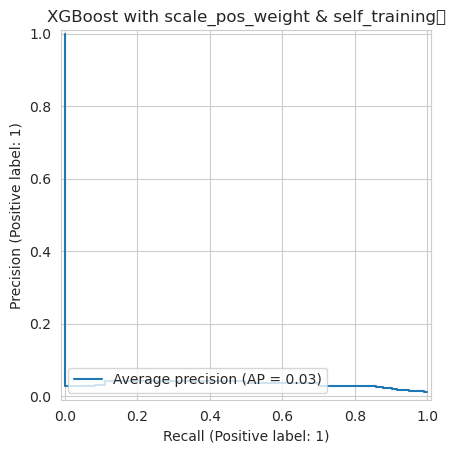

In [296]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    xgbc_classifier, X_val, y_val, name="Average precision")
_ = display.ax_.set_title("XGBoost with scale_pos_weight & self_training")

### 5.5 Kaggle Competition

In [276]:
# Make predictions on test set
test_pred = xgbc_classifier.predict(test_data)
test_pred

array([1, 1, 0, ..., 1, 1, 1])

In [279]:

# Create submission file
submission = pd.DataFrame({'LNR': mailout_test['LNR'], 'RESPONSE': test_pred})
submission.to_csv('xgboost_predictions.csv', index=False)

print("XGBoost predictions have been saved to xgboost_predictions.csv")
print(f"Number of positive predictions: {test_pred.sum()}")



XGBoost predictions have been saved to xgboost_predictions.csv
Number of positive predictions: 11053


In [278]:
len(submission)

42833